<a href="https://colab.research.google.com/github/miraytopal/Turkey-Earthquake-Tweets-Sentiment-Analysis/blob/main/Turkey_Earthquake_NLP_Sentiment_Analysis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing Libraries

In [ ]:
!pip install transformers
!pip install emoji
!pip install sentencepiece
!pip install nltk
!pip install emot==3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=0637de297bb51b9e7bff73d16ffd41829efc40c55f7034cb442571f544e02a1d
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7

In [ ]:
import pandas as pd
import numpy as np

# visualization
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

import io
from datetime import timedelta

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import re
import emoji
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


###Loading Data

In [ ]:
path = '/content/tweets.csv'
df = pd.read_csv(path)

In [ ]:
df.head()

,date,content,hashtags,like_count,rt_count,followers_count,isVerified,language,coordinates,place,source
0,2023-02-21 03:30:04+00:00,तुर्की में सोमवार देर रात भूंकप के तेज झटके मह...,"['ATDigital', 'Turkey', 'Earthquake', 'TurkeyE...",0.0000,0.0000,19727712.0000,True,hi,NaN,NaN,Twitter Media Studio
1,2023-02-21 03:29:07+00:00,New search &amp; rescue work is in progress in...,"['Hatay', 'earthquakes', 'Türkiye', 'TurkiyeQu...",1.0000,0.0000,5697.0000,True,en,NaN,NaN,Twitter Web App
2,2023-02-21 03:29:04+00:00,Can't imagine those who still haven't recovere...,"['Turkey', 'earthquake', 'turkeyearthquake2023...",0.0000,0.0000,1.0000,False,en,NaN,NaN,Twitter for Android
3,2023-02-21 03:28:06+00:00,its a highkey sign for all of us to ponder ove...,"['turkeyearthquake2023', 'earthquake', 'Syria']",0.0000,0.0000,3.0000,False,en,NaN,NaN,Twitter for Android
4,2023-02-21 03:27:38+00:00,Turkiye Earthquake: तुर्किए में फिर आया भूकंप ...,"['turkey', 'earthquake', 'turkiye', 'india', '...",0.0000,0.0000,17.0000,False,und,NaN,NaN,Twitter for Android


### Data Exploration

In [ ]:
def info(dataframe):
    print('Dataset size :', df.shape)
    print("# -------------------------------------------- #", "\n")
    print('Shape :', df.info())
    print("# -------------------------------------------- #", "\n")
    print('Shape :', df.describe())
    print("# -------------------------------------------- #", "\n")
    buf = io.StringIO()
    pd.read_csv(path).info(buf=buf)
    info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
    print('Memory usage : ', info)
    print("# -------------------------------------------- #", "\n")

info(df)

Dataset size : (445248, 11)
# -------------------------------------------- # 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445248 entries, 0 to 445247
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             445248 non-null  object 
 1   content          445248 non-null  object 
 2   hashtags         445229 non-null  object 
 3   like_count       445230 non-null  float64
 4   rt_count         445230 non-null  float64
 5   followers_count  445230 non-null  float64
 6   isVerified       445230 non-null  object 
 7   language         445230 non-null  object 
 8   coordinates      19191 non-null   object 
 9   place            18737 non-null   object 
 10  source           445230 non-null  object 
dtypes: float64(3), object(8)
memory usage: 37.4+ MB
Shape : None
# -------------------------------------------- # 

Shape :        like_count    rt_count  followers_count
count 445230.0000 445230.00

In [ ]:
# Let's take a look at the most used languages
df_language = df['language'].value_counts()
df_language[:5]

en     173361
tr     134589
qme     36983
ar      16080
qht     12495
Name: language, dtype: int64

In [ ]:
# Most used sources for tweeting
df['source'].value_counts().head()

Twitter for Android    205586
Twitter for iPhone     119452
Twitter Web App         77576
TweetDeck                5311
emsc-csem                3755
Name: source, dtype: int64

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df.head()

,date,content,hashtags,like_count,rt_count,followers_count,isVerified,language,coordinates,place,source
0,2023-02-21,तुर्की में सोमवार देर रात भूंकप के तेज झटके मह...,"['ATDigital', 'Turkey', 'Earthquake', 'TurkeyE...",0.0000,0.0000,19727712.0000,True,hi,NaN,NaN,Twitter Media Studio
1,2023-02-21,New search &amp; rescue work is in progress in...,"['Hatay', 'earthquakes', 'Türkiye', 'TurkiyeQu...",1.0000,0.0000,5697.0000,True,en,NaN,NaN,Twitter Web App
2,2023-02-21,Can't imagine those who still haven't recovere...,"['Turkey', 'earthquake', 'turkeyearthquake2023...",0.0000,0.0000,1.0000,False,en,NaN,NaN,Twitter for Android
3,2023-02-21,its a highkey sign for all of us to ponder ove...,"['turkeyearthquake2023', 'earthquake', 'Syria']",0.0000,0.0000,3.0000,False,en,NaN,NaN,Twitter for Android
4,2023-02-21,Turkiye Earthquake: तुर्किए में फिर आया भूकंप ...,"['turkey', 'earthquake', 'turkiye', 'india', '...",0.0000,0.0000,17.0000,False,und,NaN,NaN,Twitter for Android


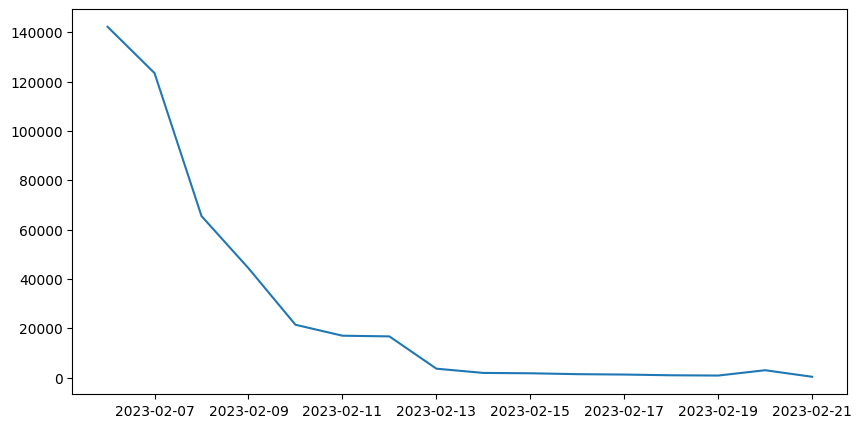

In [ ]:
# tweeting trend by day
df['date'].value_counts().plot(figsize=(10,5));

In [ ]:
# We'll go on with only Turkish tweets
df = df[df.language =='tr']

In [ ]:
df.head()

,date,content,hashtags,like_count,rt_count,followers_count,isVerified,language,coordinates,place,source
180,2023-02-21,Hayatını kaybeden çocukların anısına bazı enka...,"['earthquake', 'DEPREMANI', 'depremoldu', 'dep...",1.0000,0.0000,149.0000,False,tr,NaN,NaN,Twitter for Android
192,2023-02-21,Vatan hainleri yine TAG açmış: #70ildeOkullarK...,"['70ildeOkullarKapatılsın', 'deprem', 'earthqu...",3.0000,1.0000,0.0000,False,tr,NaN,NaN,Twitter for iPhone
213,2023-02-21,2023 Bizi Sal Artık 🤦🏻‍♀️ #earthquake #turke...,"['earthquake', 'turkeyearthquake2023', 'Turkey...",0.0000,0.0000,1252.0000,False,tr,NaN,NaN,Twitter for Android
219,2023-02-21,Türkiye'nin Güneyi ve Suriye'de 6.4 büyüklüğün...,"['Turkey', 'earthquake', 'Syria']",0.0000,0.0000,3338.0000,False,tr,NaN,NaN,Twitter for Android
257,2023-02-21,Selocum onlar istifa etmiyor. Devlet malı deni...,"['earthquake', 'Erdbeben', 'depremoldu', 'Turk...",0.0000,0.0000,297.0000,False,tr,"Coordinates(longitude=40.149462, latitude=37.8...","Place(fullName='Diyarbakır, Türkiye', name='Di...",Twitter for Android


In [ ]:
df.shape

(134589, 11)

In [ ]:
# remove duplicate tweets
df.drop_duplicates('content', inplace=True)
df.shape

(132934, 11)

###Data Cleaning

In [ ]:
def preprocess_word(word):
    
    # Convert more than 2 letter repetitions to 2 letter
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

def is_valid_word(word):
    # Check the validity of the word according to the Turkish alphabet
    return (re.search(r'^[a-zA-Z0-9ğüışöçIİĞÜŞÖÇ]+$', word) is not None)

def remove_emoji(tweet):
  
  # Positive emojis
  tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:\s?D|:-D|x-?D|X-?D|<3|:\*)', '', tweet)
  # Negative emojis
  tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|:\s?\(|:-\(|\)\s?:|\)-:|:,\(|:\'\(|:"\(', '', tweet)

  emoji_pattern = re.compile(
    '['
    u'\U0001F600-\U0001F64F'  # emoticons
    u'\U0001F300-\U0001F5FF'  # symbols & pictographs
    u'\U0001F680-\U0001F6FF'  # transport & map symbols
    u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
    u'\U00002702-\U000027B0'
    u'\U000024C2-\U0001F251'
    ']+',
    flags=re.UNICODE)
  
  tweet = emoji_pattern.sub(r'', tweet)
  
  return tweet

def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    
    #Clean only digits
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)

    # Remove URLs, user mentions and hashtags
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+)|(@[\S]+)|(#(\S+)))', '', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    #remove emojis
    tweet = remove_emoji(tweet)
    
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
      word = preprocess_word(word)
      if is_valid_word(word):      
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [ ]:
df["content"] = df.content.map(preprocess_tweet)

In [ ]:
df.head()

,date,content,hashtags,like_count,rt_count,followers_count,isVerified,language,coordinates,place,source
180,2023-02-21,hayatını kaybeden çocukların anısına bazı enka...,"['earthquake', 'DEPREMANI', 'depremoldu', 'dep...",1.0000,0.0000,149.0000,False,tr,NaN,NaN,Twitter for Android
192,2023-02-21,vatan hainleri yine tag en okullar açik açik m...,"['70ildeOkullarKapatılsın', 'deprem', 'earthqu...",3.0000,1.0000,0.0000,False,tr,NaN,NaN,Twitter for iPhone
213,2023-02-21,bizi sal artık,"['earthquake', 'turkeyearthquake2023', 'Turkey...",0.0000,0.0000,1252.0000,False,tr,NaN,NaN,Twitter for Android
219,2023-02-21,türkiyenin güneyi ve suriyede büyüklüğündeki d...,"['Turkey', 'earthquake', 'Syria']",0.0000,0.0000,3338.0000,False,tr,NaN,NaN,Twitter for Android
257,2023-02-21,selocum onlar istifa devlet malı deniz yemeyen...,"['earthquake', 'Erdbeben', 'depremoldu', 'Turk...",0.0000,0.0000,297.0000,False,tr,"Coordinates(longitude=40.149462, latitude=37.8...","Place(fullName='Diyarbakır, Türkiye', name='Di...",Twitter for Android
